## Detection tutorial


Detectools aims to provide to generalize trainning and inference processes for detection & instance segmentation models. As each model has it's specific data format and data structure it can be time consumming to try one model then another etc. To tackle this issue detectools define a common data structure (Data stored on computer) and python data format (data on python classes) for all models in library. Moreover detectools provides trainning and inference pipelines to develop and deploy models.

### Data structure

To use detectools data should be stored with the following structure:

    . Dataset Name
            ├── images
                ├── name01.png
                ├── name02.png
                └── ...
            └── coco_annotations.json

File "coco_annotations.json" contain detection annotations in [COCO format](https://cocodataset.org/#format-data). This structure is compatible with the DetectionDataset class which is a torch.Dataset and support batchification with Dataloaders.

### 0. Setup envrionnement for tutorial

In the following cell you should set up the environnement for the tutorial. You should provide the device you want to work on (CPU or GPU), the path to a dataset (with the structure above), the path to a folder for outputs of the tutorial and the number of classes on your dataset.

This tutorial will not handle instance_segmentation task. If you want to learn about instance segmentation task with detectools you should follow the tutorial "overall_instance_segmentation.ipynb".

In [1]:
from pathlib import Path
import shutil

dataset_path = "../../../../data/dev/maize" # path to prepared dataset
output_path = "../../../detection_tutorial_output" # where to store outputs
num_classes = 1 # number of classes in your dataset
batch_size = 4 # Size of batch depending on your ressources
device = "cuda" # "cuda" for GPU

# remove existing output_folder if already exists
if Path(output_path).exists():
    shutil.rmtree(output_path)

### 1. Data preparation

Some functions are provided in detectools.utils.data_mangement.py to manage your data (splitting dataset, merging jsons, ...). This functions works on the data structure on storage. Here we will split randomly the dataset in 3 subsets for train, valid and test.

In [2]:
from detectools.data_management import split_dataset

split = (0.6, 0.2, 0.2) # train, valid, test proprotions
splitted_dataset_path = f"{output_path}/split_data"
split_dataset(dataset_path, splitted_dataset_path, proportions=split)

/home/lucas/Documents/venvs/detectools/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Splitting dataset: ../../../../data/dev/maize
Export train data:


Exporting: 100%|██████████| 6/6 [00:00<00:00, 52.13it/s]


Export valid data:


Exporting: 100%|██████████| 2/2 [00:00<00:00, 29.71it/s]


Export test data:


Exporting: 100%|██████████| 2/2 [00:00<00:00, 23.06it/s]


### 2. Data format

Detectools define a common detection data format (boxes, labels) for all operations in library. This format supports many transformations (such as NMS, padding, cropping or even slicing). Annotations and predictions are stored in this format.

* spatial_size: (H, W), shape of corresponding image.
* labels: (N,) values of objects classes.
* boxes : Shape (N, 4) for N objects and 4 values of boxes (can be in different format according to box_format, default is coco XYWH).
* scores (optionnal): Scores are confidence of predictions of shape (N,)
* box_format: The boxes format ("XYWH", "CXCYWH", "XYXY"). Default to "XYWH".

In this format, one object is defined by all values of labels, boxes and other tensors of shape (N, ...) at the same index. For example, object 3 is the combinations of labels[2], boxes[2]. 

Let's create a dummy format:

In [3]:
import torch
from detectools.formats import Format

spatial_size = (1024, 1024) # H, W of dummy image
boxes = torch.tensor([[50,120,140,130], [500,260,80,120], [5,10,200,250]]) # shape (N, 4), N objects and x, y, width, height (x,y top left corner point)
labels = torch.tensor([0,1,1]) # shape N for N objects. Values are classes values.
target = Format(spatial_size, labels, boxes)

print(type(target))
print(target.size, target.spatial_size)


<class 'detectools.formats.detection_format.DetectionFormat'>
3 (1024, 1024)


You can see that the class of target is "DetectionFormat". As the library manage both detection and instance segmentation, Format class is a common interface that send to DetectionFormat or SegmentationFormat depending on the mode task you need to work on (see overall_instance_segmentation.ipynb tutorial for more information).

Data can be accessed with the method **get** and can be passed with the function **set** after Format construction. It is also possible to pass other values to formats as long as they are either tensors with shape (N, ...) or Sequence. All values are stored in data dict in Format. For more information you can see the formats modules in library.

In [4]:
target.set("labels", torch.tensor([3,4,3])) # change labels
boxes, labels = target.get("boxes", "labels")
print(boxes, labels)

# adding new informations on object size: 0 for small, 1 for large
object_size = torch.tensor([0,1,0])
target.set("object_sizes", object_size)

# print number of objects
print(target.size)
# display data dict
print(target.data)

BoundingBoxes([[ 50, 120, 140, 130],
               [500, 260,  80, 120],
               [  5,  10, 200, 250]], dtype=torch.int32, format=BoundingBoxFormat.XYWH, canvas_size=(1024, 1024)) tensor([3, 4, 3])
3
{'boxes': BoundingBoxes([[ 50, 120, 140, 130],
               [500, 260,  80, 120],
               [  5,  10, 200, 250]], dtype=torch.int32, format=BoundingBoxFormat.XYWH, canvas_size=(1024, 1024)), 'labels': tensor([3, 4, 3]), 'object_sizes': tensor([0, 1, 0])}


Slicing the Format return another Format with a subset of objects. Individual objects can also be gathered true the get_object() method. It returns an instance of Annotation class. This class store data of the object and allow to export data in COCO format (dict of COCO key values for 1 annotation).

In [5]:
subset_format = target[[0,2]]
wanted_object = target.get_object(1)
coco_like_data = wanted_object.object_to_coco()

print(target.size, subset_format.size)
print(type(wanted_object), wanted_object.boxe)
print(coco_like_data)


3 2
<class 'detectools.formats.detection_format.DetectionAnnotation'> tensor([500, 260,  80, 120], dtype=torch.int32)
{'id': 1, 'bbox': [500, 260, 80, 120], 'category_id': 4, 'image_id': 1}


### 3. DetectionDataset & DetectionLoader

Detectools provide a specific dataset to access data directly from data structure. This dataset supports preprocessing (default to imagenet preprocessing) & augmentation (default to None). Getitem of dataset return image as tensor and corresponding annotation as Format. You can pass few arguments to process some transformations within the dataset:

* augmentation
* preprocessing
* convert_labels_dict (to dynamically convert labels with a dict of conversion)
* min_border_size (minimum border size of boxes to consider object as true object, remove all objects with border smaller than this value)

In [6]:
from detectools.data import DetectionDataset

dataset = DetectionDataset(dataset_path)

image, target, name = dataset[0]
print(image.shape, target.size)

torch.Size([3, 1024, 1024]) 16


With the DetectionDataset you can also gather data from a specific image by providing the name of image with the following method:

In [7]:
image, target = dataset.get_image_data(name)

This dataset can be wrapped in a DetectionLoader thant process specific collate for targets (format). It returns images with shape (N, 3, H, W) with N the batch size and a BatchedFormat that contains Format for all images in a dict.

In [8]:
from detectools.data import DetectionLoader

loader = DetectionLoader(dataset, batch_size=batch_size)
for i, (batch_images, batch_targets, names) in enumerate(loader):
    # get size of each format in batch_targets
    sizes = [f.size for f in batch_targets.formats.values()]
    print(batch_images.shape, sizes)
    print(names)
    # break after 10 iterations
    if i >= 10:
        break

torch.Size([4, 3, 1024, 1024]) [16, 20, 20, 21]
{0: 'plot_23ZS34_Y16X005_DJI_20230530145203_0552_crop1_(1050, 778)_(2074, 1802).png', 1: 'plot_23ZS34_Y16X009_DJI_20230530144628_0300_crop1_(987, 521)_(2011, 1545).png', 2: 'plot_23ZS34_Y17X010_DJI_20230530144413_0199_crop1_(1095, 1565)_(2119, 2589).png', 3: 'plot_23ZS34_Y17X004_DJI_20230530145831_0682_crop1_(1052, 790)_(2076, 1814).png'}
torch.Size([4, 3, 1024, 1024]) [23, 18, 20, 18]
{0: 'plot_23ZS34_Y16X003_DJI_20230530145903_0707_crop1_(1155, 1924)_(2179, 2948).png', 1: 'plot_23ZS34_Y15X009_DJI_20230530144622_0296_crop1_(993, 432)_(2017, 1456).png', 2: 'plot_23ZS34_Y17X009_DJI_20230530144633_0304_crop1_(979, 1669)_(2003, 2693).png', 3: 'plot_23ZS34_Y15X005_DJI_20230530145158_0548_crop1_(1063, 1823)_(2087, 2847).png'}
torch.Size([2, 3, 1024, 1024]) [18, 23]
{0: 'plot_23ZS34_Y15X004_DJI_20230530145820_0674_crop1_(1055, 191)_(2079, 1215).png', 1: 'plot_23ZS34_Y16X002_DJI_20230530150112_0804_crop1_(1037, 1097)_(2061, 2121).png'}


DetectionLoader supports batchification with images with different shapes. It always pad all images to fit the maximum height & widdth of the batch. 

### 4. Augmentation

Detectools provide an augmentation class that can apply every transformations of torchvisions.transforms.v2 to images and boxes. This class takes list of transforms where parameters have been set.

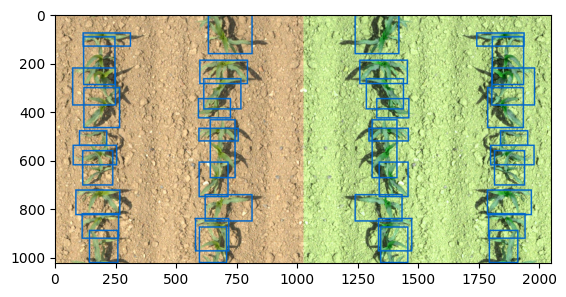

In [9]:
import torchvision.transforms.v2 as T
from computervisiontools.preprocessing import build_preprocessing
from computervisiontools import to_numpy
from detectools.visualisation import visualisation
from detectools.data import Augmentation
import matplotlib.pyplot as plt

# create augmentation
transforms = [
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(hue=0.2, brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomPerspective(p=0.5, distortion_scale=0.3)
]
augment = Augmentation(transforms)
# shut down preprocessing to gather image in uint8
dataset.preprocessing = None
image, target, name = dataset[1]
augmented_image, augmened_target = augment(image, target)
# create visualisation
raw_visualisation = visualisation(image, target)
augmented_visualisation = visualisation(augmented_image, augmened_target)
concat = torch.cat([raw_visualisation, augmented_visualisation], dim=2)
# display augmentation
plt.imshow(to_numpy(concat))

# Put back the preprocessing for follwing steps
dataset.preprocessing = build_preprocessing()

***Warning***: Torchvision.transforms.v2 that process ***rotations*** on boxes & masks can lead some inconsistent results (masks without boxes and boxes without masks). This is due to torchvision library. We recommend to limit the use of these transformations. If you wish to apply such transformations we recommend to process as follow:

Write the Augmentation class with this specific order:

1. Padding (RandomCrop(size, pad_if_needed=True)).
2. Rotations (RandomAffine, RandomRotations, etc..)
3. CenterCrop(size)

Following this the boxes should follow but we recommend to visalize your augmentations results to be sure that is correct.

### 5. Trainning

Detectools provide a Trainer class that wrap process of trainning (train epoch, valid epoch, metric computation, tensorboard writing). Let's define a better environnement for trainning by create train dataset and valid dataset. We will reuse the splitting we did on our dataset in step 1 and pass augmentation to train.

In [10]:
train_set = DetectionDataset(f"{output_path}/split_data/train", augmentation=augment)
valid_set = DetectionDataset(f"{output_path}/split_data/valid")

train_loader = DetectionLoader(train_set, batch_size=batch_size)
valid_loader = DetectionLoader(valid_set, batch_size=batch_size)

#### 5.1 Model

Models provided by the library are in detectools.models. Each model inheriths from BaseModel and have the same methods but they have also specific methods to convert data formats from detectools to their formats and vice versa. Those functions don't need to be called by user directly. Some common attributes can be passed on model creation, for instance the three parameters of instances selection for prediction (max_detections, confidence_thresold, nms_threshold).

* confidence_thr: Threshold on confidence score. Only objects with confidence higher than this threshold will be kept. (Default 0.5).
* nms_threshold: Box IoU threshold to consider objects as overlapping during Non Max suppression algortihm. (Default 0.45).
* max_detections: Keep at max N objects with higer scores (N == max_detections). (Default to 100).

New models can be added to the library as long as they respect methods from abstract class BaseModel.

Let's use a Yolov8 model.

Models can bes used directly with the native forward method, but you can use also detectools BaseModel method to get post_processed outputs as Format or compute directly loss. If you wish to work at a lower level it's necessary to learn about the functionnement of the parent class of the model. For example YoloDetection model inherits from BaseModel from detectools but also from DetectionModel from Ultralytics.

In [11]:
from detectools.models import YoloDetection

model = YoloDetection(num_classes=1)
model.eval()
# raw model utilisation
raw_outputs = model(batch_images)
print(type(raw_outputs))
# detectools prediction
prediction = model.get_predictions(batch_images)
print(prediction)
# compute loss
loss, predictions = model.run_forward(batch_images, batch_targets, predict=True)
print(loss)

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3776275  ultralytics.nn.modules.head.Detect           [1, [192, 384, 576]]          
YOLOv8m summary: 295 layers, 25856899 parameters, 25856883 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
<class 'tuple'>
{'loss': tensor(17.5365, grad_fn=<MulBackward0>), 'loss_box': tensor(2.3823), 'loss_cls': tensor(3.7363), 'loss_dfl': tensor(2.6497)}


#### 5.2 Metrics

Detectools provides some metrics for detection and instance segmentation. As detection is a composition of 2 task: detect an object and classify it, there is 2 types of metrics (DetectionMetrics and ClassificationMetrics). DetectionMetrics does not evaluate classification and vice versa. A good model is a model that obtain good performances in both detection and classification tasks. Those metrics inherith from Torchmetrics and works with the three methods update(), compute() and reset(). They accumulate and average performance accross samples and return values with all averaging methods:

* global/samplewise: to average over images or over objects in dataset (Detection & Classification).
* Micro/Macro: To average the mean/class (class proportions are erased) or mean over objects (proportions is kept).

See detectools.metrics & [torchmetrics documentation](https://lightning.ai/docs/torchmetrics/stable/) for more details.

In [12]:
from detectools.metrics import DetectF1score, ClassifF1score

detectf1 = DetectF1score()
classificationf1 = ClassifF1score(num_classes=num_classes)

detect = detectf1(target, augmened_target)
classif = classificationf1(target, augmened_target)

print(detect, classif)

detectf1.reset()
classificationf1.reset()

{'global': tensor(0.), 'samplewise': tensor(0.)} {'_global': tensor(nan), '_samplewise': tensor(nan)}


#### 5.3 Trainer & loops

Trainer objects wrap all trainning objects:

* Model
* Optimizer
* Metrics

Instance selection parameters (confidence_thr, nms_thr) defined in Trainer override the ones created in model, they can be passed as arguments of Trainer constructor.

A directory path to store tensorboard logs can also be passed to Trainer.

In [13]:
from torch.optim import Adam
from detectools.train import Trainer

optimizer = Adam(model.parameters(), lr=1e-4)
metrics = [detectf1, classificationf1]
trainer = Trainer(model, optimizer, log_dir=f"{output_path}/tensorboard_logs", metrics=metrics, device=device)

Let's train for a few epochs with train_epoch() and valid_epoch() methods:

In [14]:
for epoch in range(5): # change number of epochs according to your dataset
    trainer.train_epoch(train_loader, epoch)
    trainer.valid_epoch(valid_loader, epoch)
    print('\n')

Epoch 0/Valid: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s, loss : 6.528 loss_box : 0.911 loss_cls : 1.396 loss_dfl : 0.957 DetectF1score : 0.208 ClassifF1score : 1.0 ]


Epoch 1/Valid: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s, loss : 5.905 loss_box : 0.858 loss_cls : 1.23 loss_dfl : 0.864 DetectF1score : 0.493 ClassifF1score : 1.0 ]


Epoch 2/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s, loss : 5.484 loss_box : 0.822 loss_cls : 1.12 loss_dfl : 0.799 DetectF1score : 0.562 ClassifF1score : 1.0 ]


Epoch 3/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s, loss : 5.594 loss_box : 0.802 loss_cls : 1.196 loss_dfl : 0.799 DetectF1score : 0.559 ClassifF1score : 1.0 ]


Epoch 4/Valid: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s, loss : 5.283 loss_box : 0.769 loss_cls : 1.095 loss_dfl : 0.777 DetectF1score : 0.646 ClassifF1score : 1.0 ]

You can interact with trainer attributes during trainning and gather losss values for each epoch. For example you can add a learning rate decay, add the learnig rate value to tensorboard and manage to save only models taht reach best loss value in valid:

In [15]:
from torch.optim.lr_scheduler import ExponentialLR

lr_scheduler = ExponentialLR(trainer.optimizer, gamma=0.99)
best_loss = None

for epoch in range(20): # change number of epochs according to your dataset
    trainer.train_epoch(train_loader, epoch)
    # gather valid loss
    valid_loss = trainer.valid_epoch(valid_loader, epoch)
    print('\n')
    # add lr to board & decrease lr
    trainer.board.add_scalar("lr", lr_scheduler.get_last_lr()[0], epoch)
    lr_scheduler.step()
    # save model if best model
    if best_loss==None:
        best_loss = valid_loss["loss"]

    if valid_loss["loss"].item() < best_loss:
        torch.save(trainer.model, f"{output_path}/best.pth")
        best_loss = valid_loss["loss"]

Epoch 0/Valid: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s, loss : 5.917 loss_box : 0.723 loss_cls : 1.483 loss_dfl : 0.753 DetectF1score : 0.605 ClassifF1score : 1.0 ]


Epoch 1/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s, loss : 5.366 loss_box : 0.733 loss_cls : 1.162 loss_dfl : 0.788 DetectF1score : 0.605 ClassifF1score : 1.0 ]


Epoch 2/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s, loss : 5.155 loss_box : 0.682 loss_cls : 1.127 loss_dfl : 0.768 DetectF1score : 0.675 ClassifF1score : 1.0 ]


Epoch 3/Valid: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s, loss : 5.514 loss_box : 0.679 loss_cls : 1.316 loss_dfl : 0.762 DetectF1score : 0.682 ClassifF1score : 1.0 ]


Epoch 4/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s, loss : 5.007 loss_box : 0.7 loss_cls : 1.033 loss_dfl : 0.77 DetectF1score : 0.684 ClassifF1score : 1.0 ]


Epoch 5/Valid: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s, loss : 4.626 loss_box : 0.702 loss_cls : 0.839 loss_dfl : 0.772 DetectF1score : 0.714 ClassifF1score : 1.0 ]


Epoch 6/Valid: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s, loss : 4.707 loss_box : 0.704 loss_cls : 0.866 loss_dfl : 0.783 DetectF1score : 0.795 ClassifF1score : 1.0 ]


Epoch 7/Valid: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s, loss : 4.674 loss_box : 0.694 loss_cls : 0.854 loss_dfl : 0.789 DetectF1score : 0.784 ClassifF1score : 1.0 ]


Epoch 8/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s, loss : 4.425 loss_box : 0.679 loss_cls : 0.756 loss_dfl : 0.778 DetectF1score : 0.806 ClassifF1score : 1.0 ]


Epoch 9/Valid: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s, loss : 4.323 loss_box : 0.675 loss_cls : 0.708 loss_dfl : 0.779 DetectF1score : 0.743 ClassifF1score : 1.0 ]


Epoch 10/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s, loss : 4.359 loss_box : 0.684 loss_cls : 0.717 loss_dfl : 0.778 DetectF1score : 0.73 ClassifF1score : 1.0 ]


Epoch 11/Valid: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s, loss : 4.336 loss_box : 0.655 loss_cls : 0.762 loss_dfl : 0.751 DetectF1score : 0.73 ClassifF1score : 1.0 ]


Epoch 12/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s, loss : 4.157 loss_box : 0.661 loss_cls : 0.662 loss_dfl : 0.755 DetectF1score : 0.732 ClassifF1score : 1.0 ]


Epoch 13/Valid: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s, loss : 4.083 loss_box : 0.664 loss_cls : 0.615 loss_dfl : 0.763 DetectF1score : 0.761 ClassifF1score : 1.0 ]


Epoch 14/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s, loss : 3.993 loss_box : 0.651 loss_cls : 0.594 loss_dfl : 0.752 DetectF1score : 0.743 ClassifF1score : 1.0 ]


Epoch 15/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s, loss : 3.907 loss_box : 0.623 loss_cls : 0.612 loss_dfl : 0.719 DetectF1score : 0.725 ClassifF1score : 1.0 ]


Epoch 16/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s, loss : 3.906 loss_box : 0.626 loss_cls : 0.611 loss_dfl : 0.716 DetectF1score : 0.743 ClassifF1score : 1.0 ]


Epoch 17/Valid: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s, loss : 3.919 loss_box : 0.628 loss_cls : 0.6 loss_dfl : 0.732 DetectF1score : 0.754 ClassifF1score : 1.0 ]


Epoch 18/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s, loss : 3.911 loss_box : 0.631 loss_cls : 0.579 loss_dfl : 0.745 DetectF1score : 0.754 ClassifF1score : 1.0 ]


Epoch 19/Valid: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s, loss : 3.859 loss_box : 0.633 loss_cls : 0.549 loss_dfl : 0.748 DetectF1score : 0.754 ClassifF1score : 1.0 ]


### Inference

Detectools provide a wrapper class to run inference: Predictor. This class will manage the forward pass on image, the visualisation and the export in JSON format. As images to predict can be much more larger than patches used for trainning, Detectools provide an algorithm to patchify the inference. Large images will be cut in smaller patches, with optionnaly an overlap between these patches. Each patch is predicted than all are merged together. To remove remove dummy predictions caused by merging (objects at frontiers of multiple patchs) Predictor will apply  a NMS algotithm after merging. If no patch_size is provided at Predictor construction, the default patch_size will be size of image. Some models aren't sensitive to the change of scale (i.e. YOLO) and some are (Mask2Former).

Once again the three parameters of instance predictions can be defined in the Predictor construction:

* confidence_thr
* nms_thr
* max detections

Let's do some predictions with our model. Be aware that if the dataset you provide is very large or if the task is complex you may not see any results in the following case. To insure to have some results you can work on very small dataset or try to overfit and predict on trainning set.

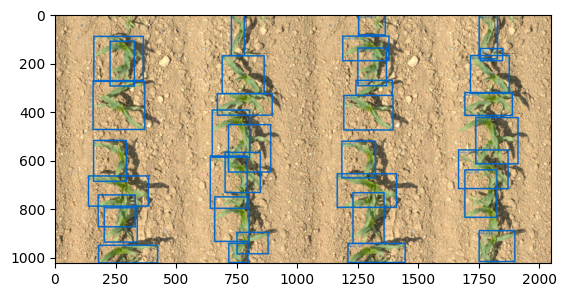

In [16]:
from detectools.inference import Predictor

model = torch.load(f"{output_path}/best.pth")
dataset = DetectionDataset(f"{output_path}/split_data/test", preprocessing=None)
image, target, name = dataset[0]

predictor = Predictor(model, device=device)
predictions = predictor.predict(image, visualisation_path=f"{output_path}/test_visualisation.png")

target_visualisation = visualisation(image, target)
prediction_visualisation = visualisation(image, predictions, classes=dataset.classes)
concat = torch.cat([target_visualisation, prediction_visualisation], dim=2)

plt.imshow(to_numpy(concat))